In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, forecast_by_week, train_test_split
from PythonFiles.PlottingFunctions import plot_coverage, print_forecasts_by_week, hyperparameter_boxplots, plot_model_results_by_hp,\
hp_color_plot, plot_forecast_entry
from PythonFiles.Configuration import Configuration
from PythonFiles.HpTuning import get_data, objectiveFNN
from datetime import datetime
import mxnet as mx
from gluonts.mx import Trainer, DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.mx.model.simple_feedforward import SimpleFeedForwardEstimator
mx.random.seed(0)
np.random.seed(0)

In [2]:
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
config = Configuration()
# import the data
influenza_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=',')
population_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/PopulationVector.csv", sep=',')
neighbourhood_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/AdjacentMatrix.csv", sep=',', index_col=0)

data_splits_dict = {}
locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date','week']]
df = preprocessing(config, df, check_count=False, output_type="corrected_df")
for location in locations:
    df.loc[df.location == location, "population"] = int(population_df.loc[population_df.Location == location, "2011"].values[0])
    df.loc[df.location == location, locations] = neighbourhood_df.loc[neighbourhood_df.index==location,locations].values[0].astype(int)

config.train_start_time = datetime(1999,1,1,0,0,0)
config.train_end_time = datetime(2018,9,30,23,0,0)
config.test_end_time = datetime(2020,9,30,23,0,0)
data_splits_dict["with_features_2001"] = list(train_test_split(config, df, True))

locations = list(df.location.unique())
train = data_splits_dict["with_features_2001"][0]
test = data_splits_dict["with_features_2001"][1]

In [3]:
results_dict = np.load('/home/reffert/DeepAR_InfluenzaForecast/ignore_this_directory/default_models_validation.npy',allow_pickle='TRUE').item()
forecasts_dict, evaluator_df_dict = forecast_by_week(config, train, test, locations, models_dict = {"DeepAR":None, "FNN":None}, seed=0, results_dict=results_dict)

Running evaluation: 411it [00:02, 153.60it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 153.86it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 151.86it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 153.94it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 146.30it/s

DeepAR
          item_id    mean_WIS
0  aggregated {1}  238.896959
0  aggregated {2}  338.585680
0  aggregated {3}  434.091919
0  aggregated {4}  495.709055
FNN
          item_id    mean_WIS
0  aggregated {1}  245.674314
0  aggregated {2}  369.000834
0  aggregated {3}  512.397445
0  aggregated {4}  689.824279


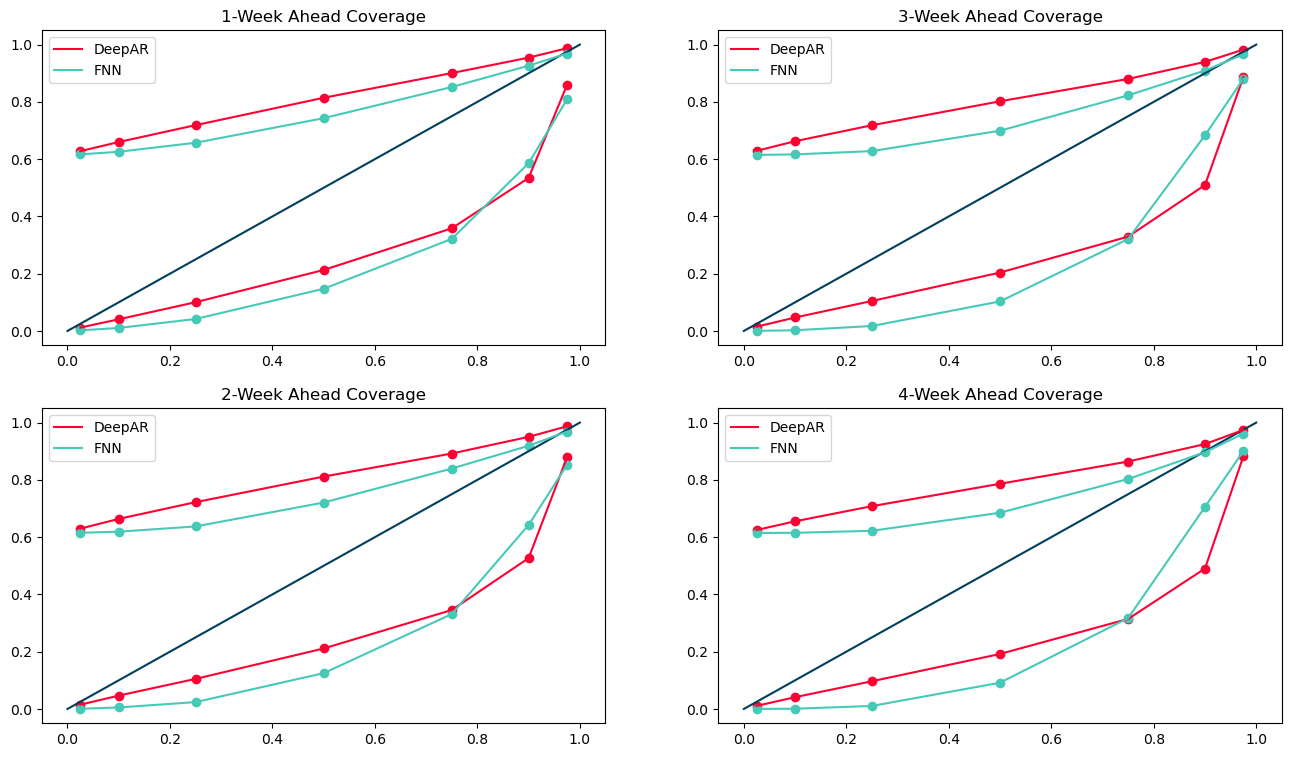

In [4]:
plot_coverage(config, evaluator_df_dict, strict=True)
for key in evaluator_df_dict.keys():
    print(key)
    print(evaluator_df_dict[key].loc[evaluator_df_dict[key]["mean_WIS"]>0, ["item_id","mean_WIS"]])

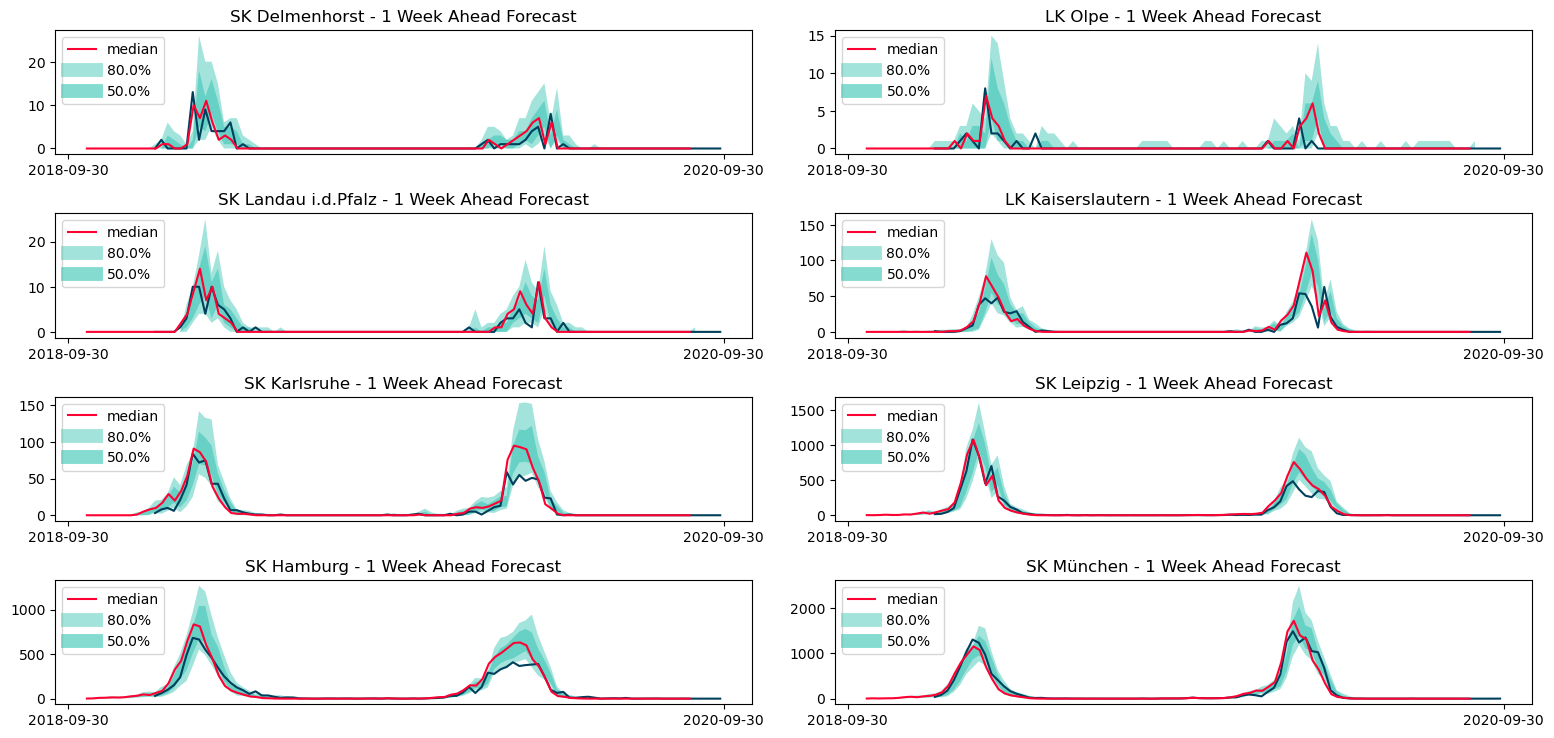

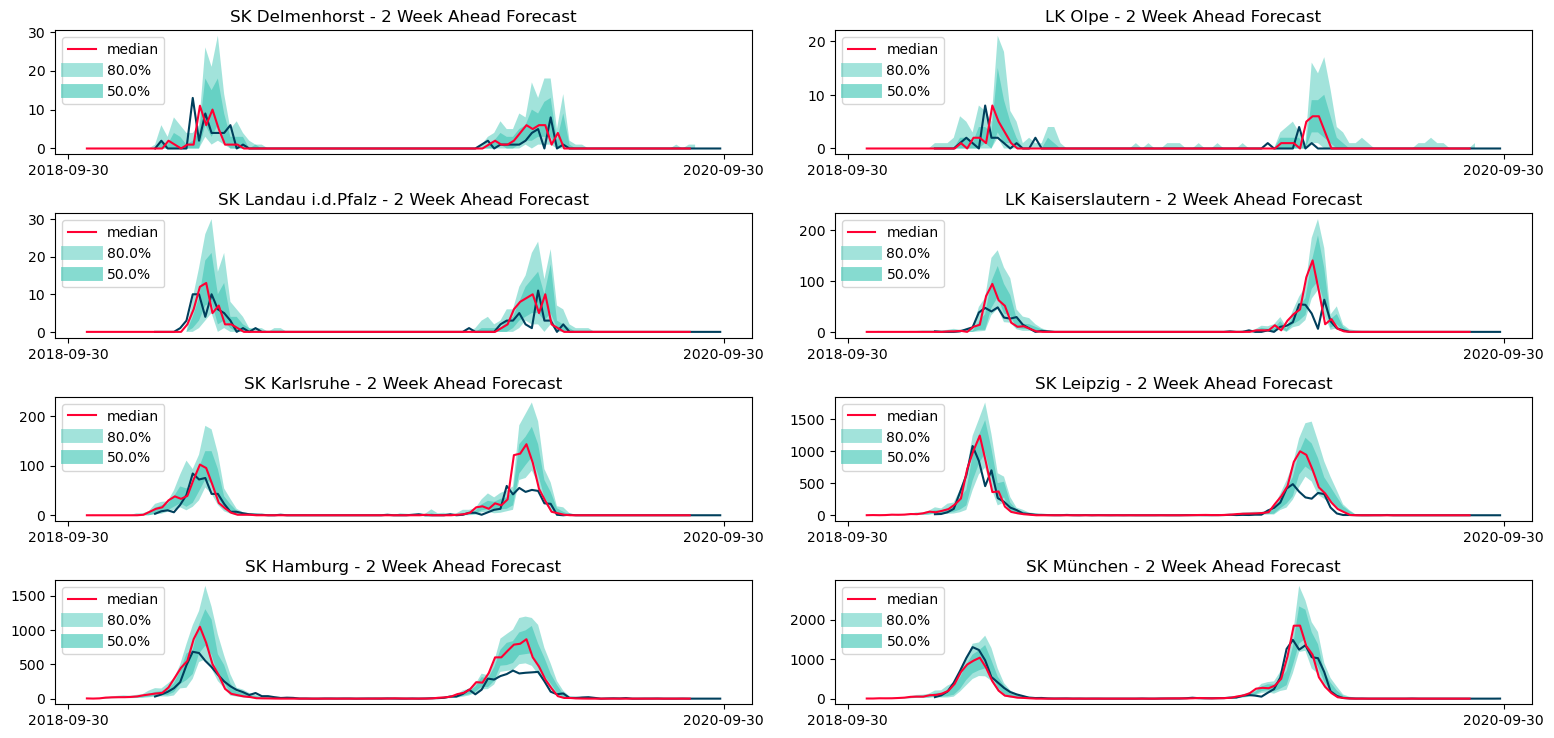

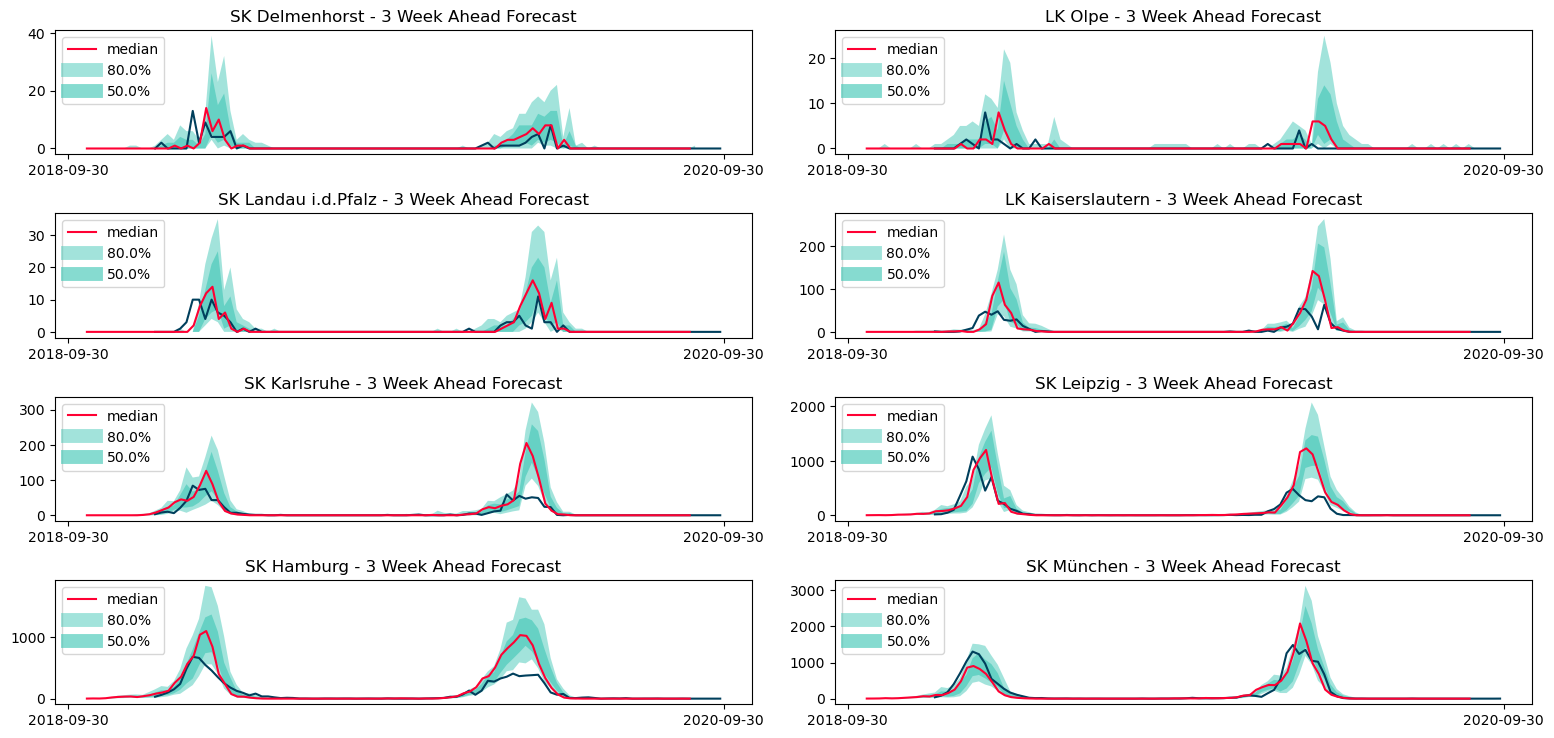

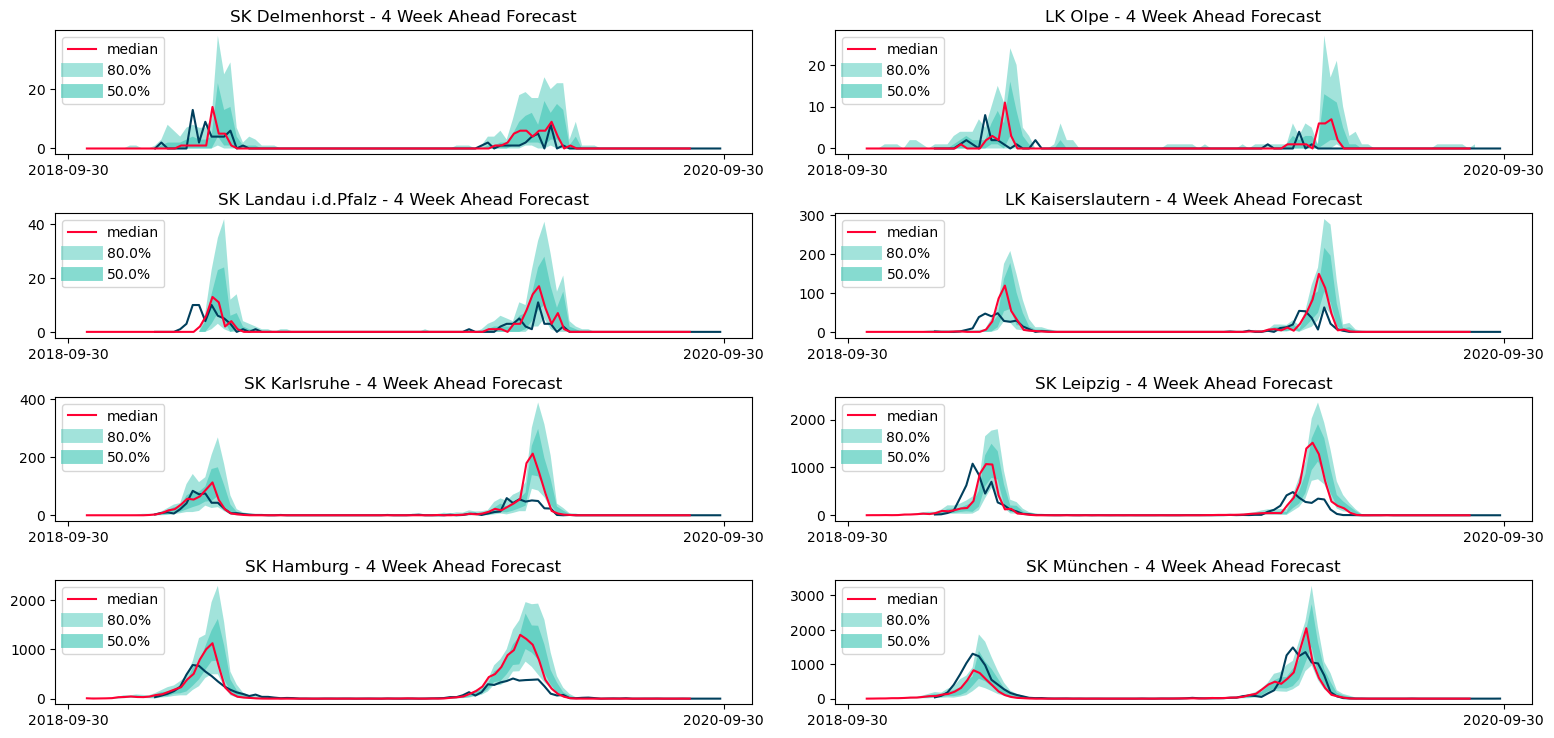

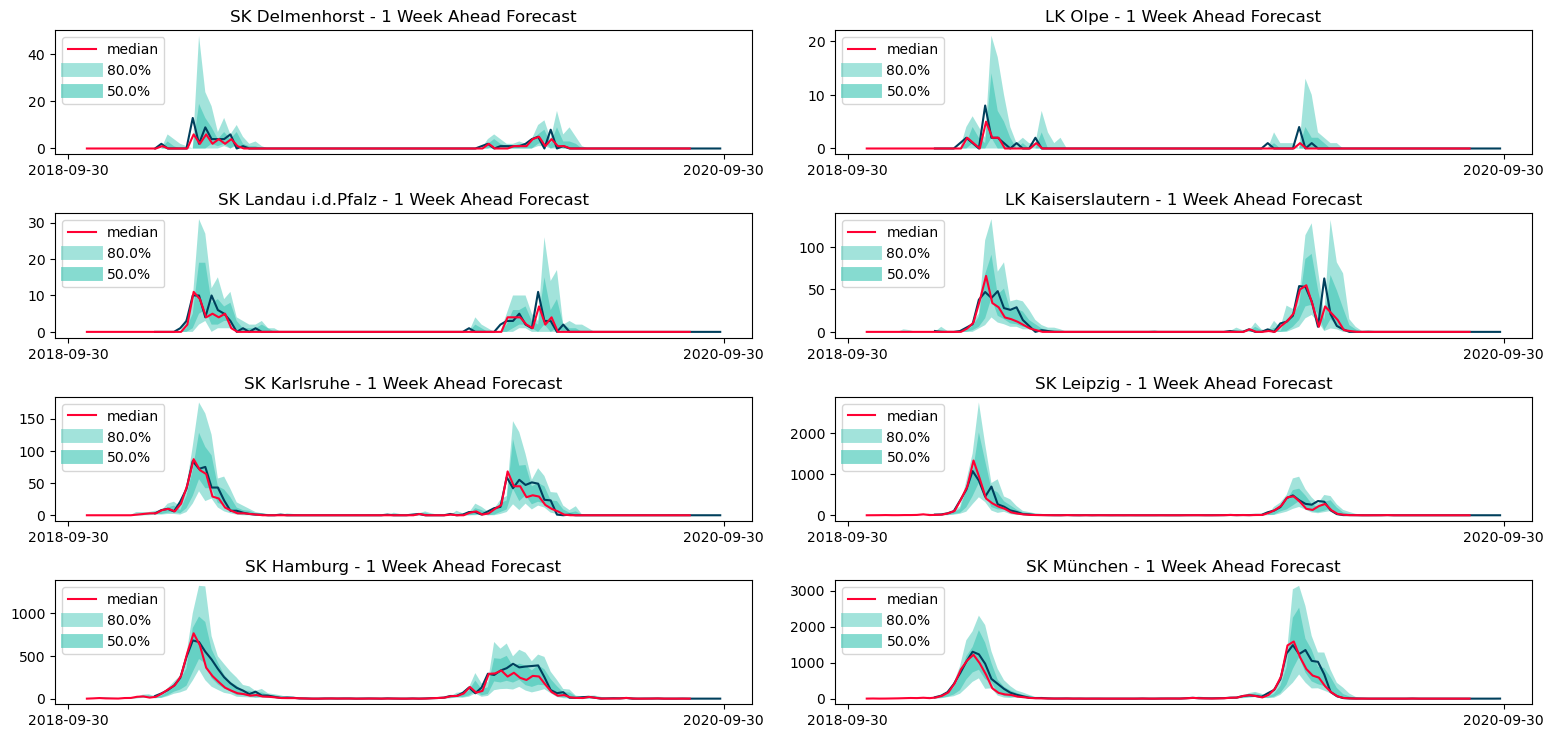

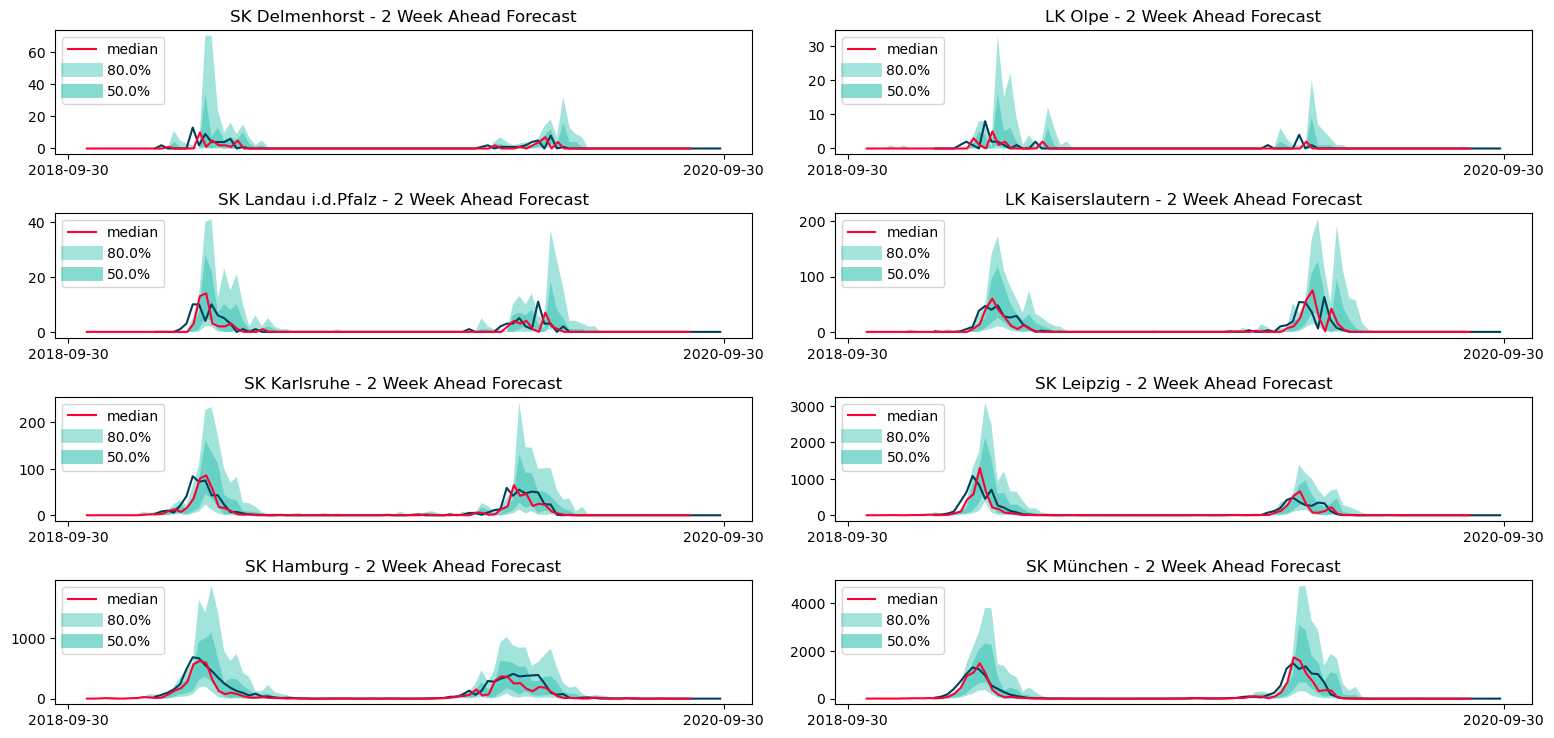

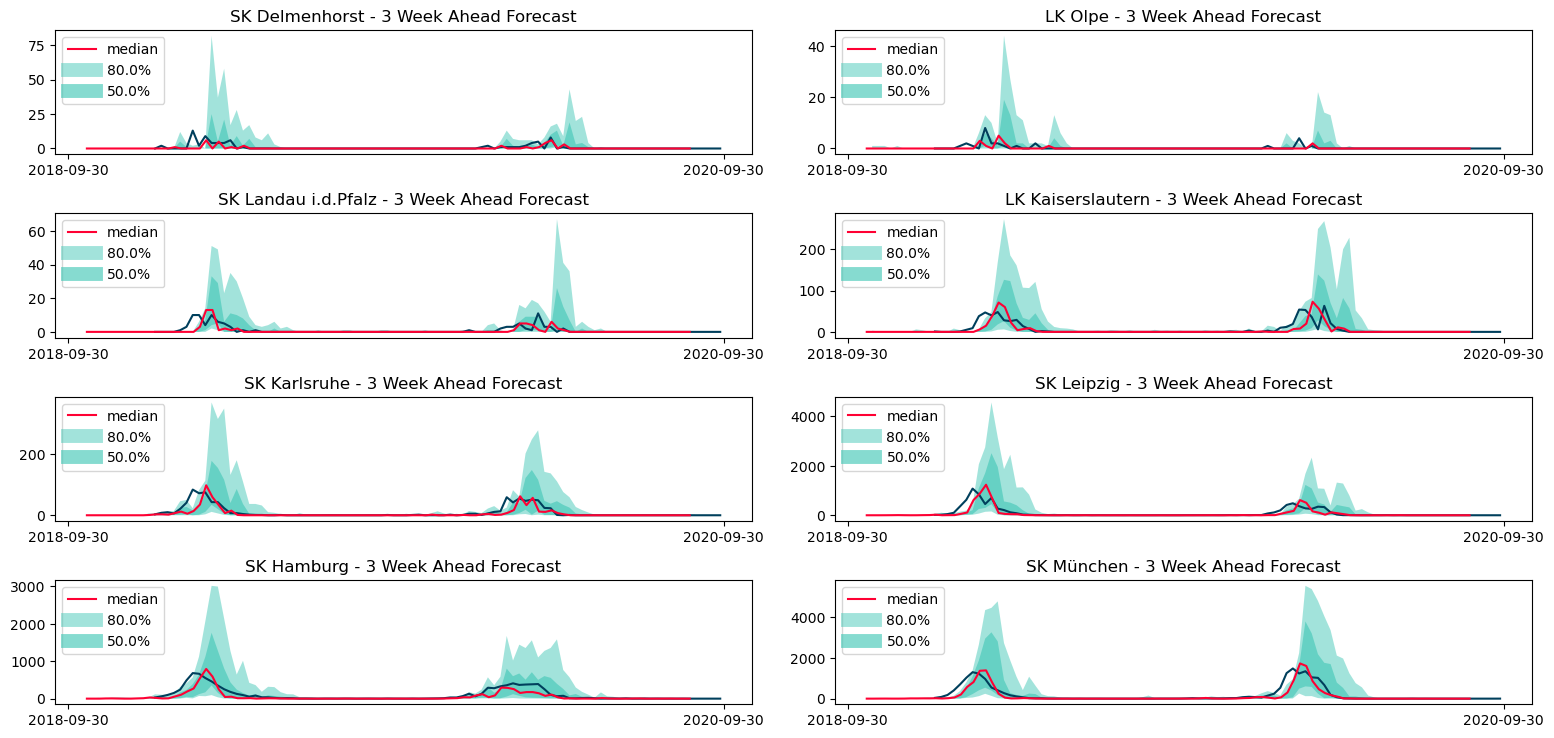

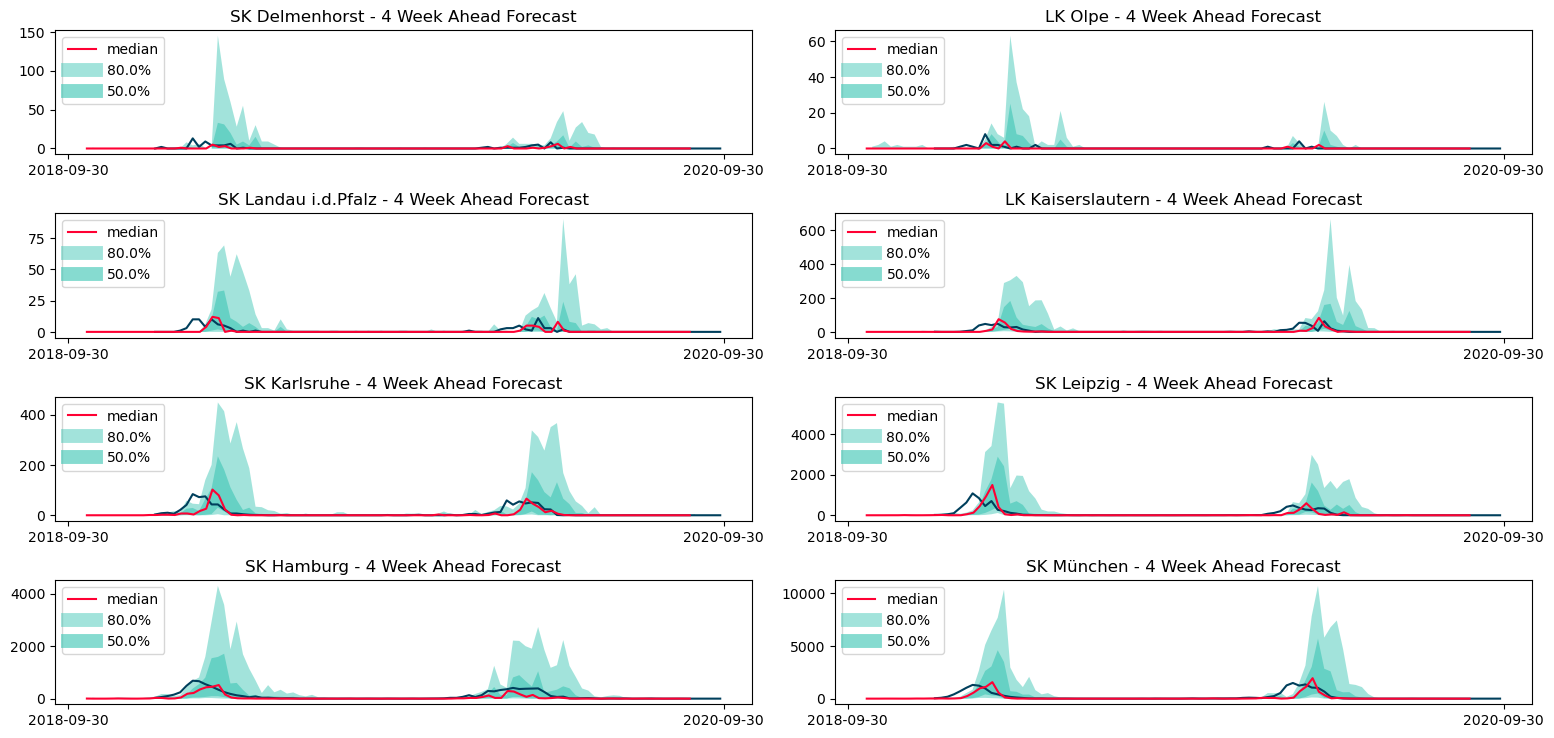

In [5]:
selected_regions = ['SK Delmenhorst','LK Olpe', 'SK Landau i.d.Pfalz','LK Kaiserslautern','SK Karlsruhe', 'SK Leipzig','SK Hamburg', 'SK München']
print_forecasts_by_week(config, df, forecasts_dict, selected_regions, [1,2,3,4], plot_begin_at_trainstart=datetime(2019,1,1,0,0,0),)
                         #savepath='/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FigureCreation', filename=f"Default_")

In [ ]:
location = "SK München"
forecast_dict = forecasts_dict["DeepAR"]     
fe = forecast_dict[list(forecasts_dict["DeepAR"].keys())[1-1]][locations.index(location)]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.plot(df.loc[(df['location'] == location) &(df.index <= config.test_end_time) &(df.index >= datetime(2016,8,1))].index,
         df.loc[(df['location'] == location) &(df.index <= config.test_end_time) &(df.index >= datetime(2016,8,1)),'value'],
         c=config.colors[0])
plot_forecast_entry(config, fe, show_mean=False, meancolor=config.colors[1],ax=None, mediancolor=config.colors[1],fillcolor=config.colors[4], axis=False)
plt.legend(loc="upper left")
plt.title(f"{location}")
plt.show()

# Fitting of the models and Forecasting to produce the same file contained in results_dict

In [7]:
default_fnn_estimator = SimpleFeedForwardEstimator(num_hidden_dimensions=None, prediction_length=4, context_length=None,
                                                  distr_output=config.fnnparameters["distr_output"], batch_size=32,
                                                  batch_normalization=False, trainer=Trainer(epochs=100,num_batches_per_epoch=50)
                                                  )
default_deepar_estimator = DeepAREstimator(freq=config.parameters["freq"],
                        context_length=4,
                        prediction_length=4,
                        num_layers=2,
                        num_cells=40,
                        cell_type="lstm",
                        trainer=Trainer(epochs=100),
                        distr_output=config.parameters["distr_output"],
                        use_feat_static_real=False,
                        use_feat_static_cat=False,
                        use_feat_dynamic_real=False)
estimators = {"DeepAR":default_deepar_estimator, "FNN":default_fnn_estimator}
results_dict = {}
for key in estimators.keys():
    predictor = estimators[key].train(train)
    forecast_it, ts_it = make_evaluation_predictions(dataset=test, predictor=predictor,num_samples=100)
    results_dict[f"{key}_forecasts"] = list(forecast_it)
    results_dict[f"{key}_tss"] = list(ts_it)
np.save('/home/reffert/DeepAR_InfluenzaForecast/ignore_this_directory/default_models_validation.npy', results_dict) 

'\nestimators = {"DeepAR":default_deepar_estimator, "FNN":default_fnn_estimator}\nresults_dict = {}\nfor key in estimators.keys():\n    predictor = estimators[key].train(train)\n    forecast_it, ts_it = make_evaluation_predictions(dataset=test, predictor=predictor,num_samples=100)\n    results_dict[f"{key}_forecasts"] = list(forecast_it)\n    results_dict[f"{key}_tss"] = list(ts_it)\nnp.save(\'/home/reffert/DeepAR_InfluenzaForecast/ignore_this_directory/default_models_validation.npy\', results_dict) '